In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from skimage.feature import greycomatrix, greycoprops
from skimage import color
from skimage import io
from skimage import exposure
import natsort as ns
from PIL import Image

In [4]:
path = os.getcwd()

im_dir = r''+ path + '/Zurich_dataset/images_tif/'
gt_dir = r''+ path + '/Zurich_dataset/groundtruth/'

im_names = ns.natsorted(os.listdir(im_dir))
gt_names = ns.natsorted(os.listdir(gt_dir))
print("images: %i " % len(im_names))
print("ground truth images: %i " % len(gt_names))

images: 20 
ground truth images: 20 


In [5]:
def imgs_stretch_eq(image):
    # Contrast stretching of every band to its percentiles 2, 98
    img_stretch = image.copy()
    img_eq = image.copy()
    for band in range(np.shape(image)[-1]):
        p2, p98 = np.percentile(image[:,:,band], (2, 98))
        img_stretch[:,:,band] = exposure.rescale_intensity(image[:,:,band], in_range=(p2, p98), out_range =(0,1))
    
        # Equalization
        img_eq[:,:,band] = exposure.equalize_hist(image[:,:,band])
    return img_stretch, img_eq

def im_load(path, max_size = 256): # for now, only return highest [max_size] pixels, multiple of patch_size
    """load a TIF image"""
    image = np.asarray(io.imread(path)).astype(float)
    return np.asarray(image[:max_size,:max_size,:])


def get_im_patches(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

In [6]:
images = np.asarray([im_load(im_dir + im_name) for im_name in im_names])
gt = np.asarray([im_load(gt_dir + gt_name) for gt_name in gt_names])

In [7]:
im_stretch, im_eq = [],[]
for i in range(len(images)): # histogram stretching and equalization
    im_s, im_e = imgs_stretch_eq(images[i])
    im_stretch.append(im_s)
    im_eq.append(im_e)

In [8]:
for var in images, images[0], gt, gt[0]:
    print(var.shape)

(20, 256, 256, 4)
(256, 256, 4)
(20, 256, 256, 3)
(256, 256, 3)


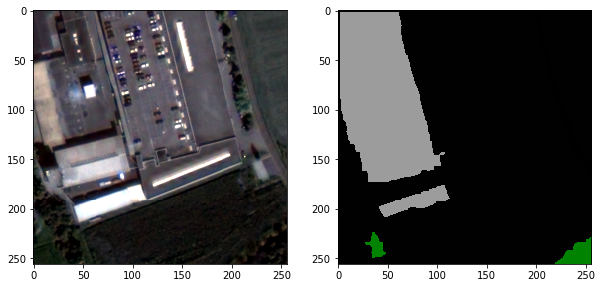

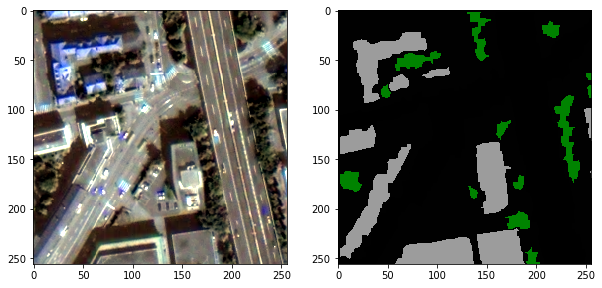

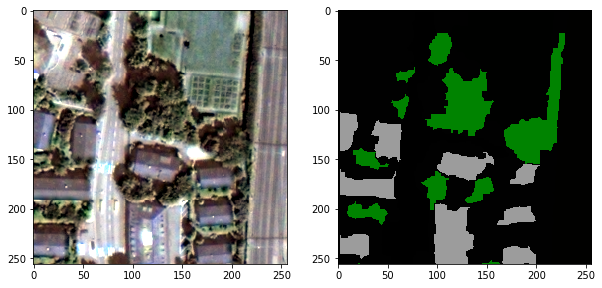

In [9]:
# Show image and its groundtruth image

images_ind = np.arange(3)
for i in images_ind:
    fig, axes = plt.subplots(1,2)
    fig.set_size_inches(10,5)
    axes[0].imshow(im_stretch[i][:,:,0:3], cmap='Greys_r')
    axes[1].imshow(gt[i], cmap='Greys_r')
    plt.show()

In [10]:
images = im_stretch # continue using stretched image

In [11]:
print(np.shape(images))
print(np.shape(gt))

(20, 256, 256, 4)
(20, 256, 256, 3)


## GT to labels
Next, we need to convert the ground truth (colors) to labels 

In [12]:
# get label corresponding to each color

legend = {'Background':[255, 255, 255],
          'Roads': [0, 0, 0],
          'Buildings': [100, 100, 100],
          'Trees':[0, 125, 0],
          'Grass': [0, 255, 0],
          'Bare Soil':[150, 80, 0],
          'Water':[0, 0, 150],
          'Railways':[255, 255, 0],
          'Swimming Pools':[150, 150, 255]}

# get class names by increasing value (as done above)
names, colors = [], []
for name, color in legend.items():
    names.append(name)
    colors.append(np.sum(color))

In [13]:
def gt_color_to_label(gt, maj = False):
    # sum of distinct color values
    gt_new = np.sum(gt,axis=3).astype(int) 

    # replace colors by new values
    for i in range(len(colors)):
        gt_new[gt_new == colors[i]] = np.argsort(colors)[i]
    
    if maj:
        # get majority label for each patch
        gt_maj_label = []
        for i in range(len(gt)):
            counts = np.bincount(gt_new[i].flatten())
            gt_maj_label.append(np.argmax(counts))

        gt_new = np.asarray([gt_maj_label]).T
        
    return gt_new

gt_maj_label = gt_color_to_label(gt)

In [14]:
np.shape(gt_maj_label)

(20, 256, 256)

In [15]:
gt = gt_maj_label

## UNET

In [253]:
def get_unet():
    inputs = Input((8, ISZ, ISZ))
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool1)
    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(pool2)
    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(pool3)
    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(pool4)
    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(conv5)

    up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=1)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(up6)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv6)

    up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=1)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(up7)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv7)

    up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=1)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up8)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv8)

    up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=1)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(up9)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv9)

    conv10 = Convolution2D(N_Cls, 1, 1, activation='sigmoid')(conv9)

    model = Model(input=inputs, output=conv10)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])
    return model

## Get patches

In [130]:
# get a lot of 32 * 32 patches
def get_patches(patch_size = 32):
    im_patches = [get_im_patches(image,patch_size,patch_size) for image in images]
    im_patches = np.asarray([im_patches[i][j] for i in range(len(im_patches)) for j in range(len(im_patches[i]))])

    gt_patches = [get_im_patches(gt_im,patch_size,patch_size) for gt_im in gt]
    gt_patches = np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])
    
    return im_patches, gt_patches

In [ ]:
figures = 6
class_ = 1

fig, axes = plt.subplots(2,figures)
fig.set_size_inches(15,5)
inds_cl = np.where(gt_patches_maj_label == class_)[0]
images_ind = np.random.choice(inds_cl, size=6)
for i in range(len(images_ind)):
    axes[0][i].imshow(im_patches[images_ind[i]][:,:,:3])
    axes[1][i].imshow(gt_patches[images_ind[i]])
    #axes[i].set_title(str(y_train[images_ind[i]]))
plt.show()

In [16]:
np.shape(gt_patches)
np.shape(gt_patches_maj_label)

(6480, 1)

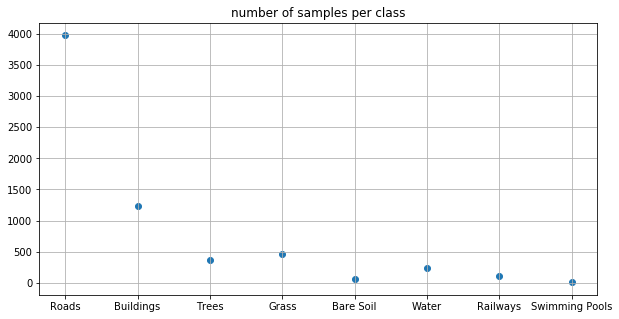

In [17]:
# print some statistics for the new labels
unique, counts = np.unique(gt_patches_maj_label,return_counts=True)
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,5)
ax.scatter(unique,counts)
ax.set_title('number of samples per class')
ax.set_xticklabels(names)
ax.grid()
plt.show()

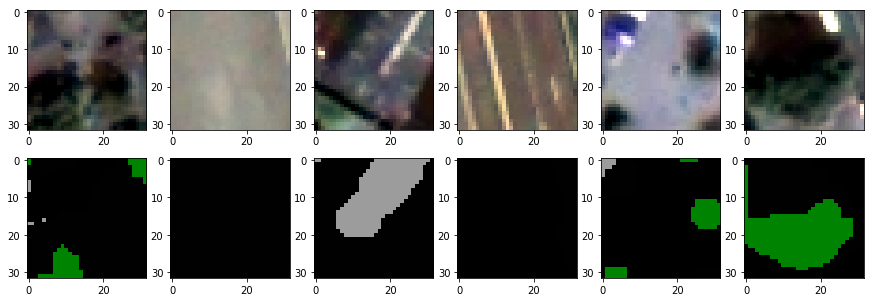

In [23]:
figures = 6
class_ = 1

fig, axes = plt.subplots(2,figures)
fig.set_size_inches(15,5)
inds_cl = np.where(gt_patches_maj_label == class_)[0]
images_ind = np.random.choice(inds_cl, size=6)
for i in range(len(images_ind)):
    axes[0][i].imshow(im_patches[images_ind[i]][:,:,:3])
    axes[1][i].imshow(gt_patches[images_ind[i]])
    #axes[i].set_title(str(y_train[images_ind[i]]))
plt.show()

Now, our training set consists of the majority label over each tile, which we can now feed into the neural network.

In [50]:
x_train, y_train = im_patches, gt_patches_maj_label

# Keras test

In [272]:
'''Train a simple deep CNN on the CIFAR10 small images dataset.
It gets to 75% validation accuracy in 25 epochs, and 79% after 50 epochs.
(it's still underfitting at that point, though).
'''

from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
#import keras.backend as K
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout, MaxPool2D, concatenate
import h5py
import ssl

ssl._create_default_https_context = ssl._create_unverified_context
import numpy as np
import os

from tensorflow.contrib.keras import models
from tensorflow.contrib.keras import layers 

In [274]:
# define data
X = np.asarray(images)
Y = np.asarray(gt)
print(np.shape(X))
print(np.shape(Y))


(20, 256, 256, 4)
(20, 256, 256)


In [275]:
"""batch_size = 32
num_classes = 10
epochs = 1 # 100
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
"""
%clear

In [277]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.2)

In [278]:
for var in x_train, y_train, x_test, y_test:
    print(np.shape(var))

(16, 256, 256, 4)
(16, 256, 256)
(4, 256, 256, 4)
(4, 256, 256)


In [279]:
x_test = x_test.reshape(x_test.shape[0], x_test.shape[3], x_test.shape[1], x_test.shape[2])
x_train = x_train.reshape(x_train.shape[0], x_train.shape[3], x_train.shape[1], x_train.shape[2])

# ultrasound-nerve-segmentation

https://github.com/jocicmarko/ultrasound-nerve-segmentation

In [267]:
def get_unet(img_row, img_cols, ):
    inputs = Input((img_rows, img_cols, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])

    return model